In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vidurgupta7","key":"5574fa5395d8eda34b87749b20ab1f95"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!pip install -q kaggle


!kaggle datasets download -d xhlulu/140k-real-and-fake-faces


!unzip -q 140k-real-and-fake-faces.zip -d deepfake_dataset


Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.75G/3.75G [00:39<00:00, 233MB/s]
100% 3.75G/3.75G [00:39<00:00, 103MB/s]


In [ ]:
!ls -R /content/deepfake_dataset


Streaming output truncated to the last 5000 lines.
07758.jpg  17701.jpg  27836.jpg  37869.jpg  47848.jpg  57938.jpg  67873.jpg
07759.jpg  17703.jpg  27838.jpg  37870.jpg  47849.jpg  57939.jpg  67874.jpg
07760.jpg  17704.jpg  27839.jpg  37871.jpg  47850.jpg  57940.jpg  67875.jpg
07761.jpg  17706.jpg  27841.jpg  37872.jpg  47851.jpg  57941.jpg  67876.jpg
07762.jpg  17707.jpg  27842.jpg  37873.jpg  47852.jpg  57942.jpg  67877.jpg
07763.jpg  17708.jpg  27843.jpg  37875.jpg  47853.jpg  57943.jpg  67878.jpg
07764.jpg  17710.jpg  27844.jpg  37876.jpg  47854.jpg  57944.jpg  67880.jpg
07765.jpg  17713.jpg  27845.jpg  37878.jpg  47855.jpg  57946.jpg  67882.jpg
07767.jpg  17714.jpg  27846.jpg  37879.jpg  47856.jpg  57947.jpg  67883.jpg
07769.jpg  17715.jpg  27848.jpg  37880.jpg  47857.jpg  57949.jpg  67885.jpg
07771.jpg  17717.jpg  27849.jpg  37881.jpg  47858.jpg  57950.jpg  67886.jpg
07772.jpg  17720.jpg  27850.jpg  37882.jpg  47859.jpg  57952.jpg  67887.jpg
07774.jpg  17721.jpg  27851.jpg  3788

In [ ]:
!find /content/deepfake_dataset -name "*.csv"


/content/deepfake_dataset/valid.csv
/content/deepfake_dataset/test.csv
/content/deepfake_dataset/train.csv


loading CSV FILE into the dataframe

In [ ]:
import pandas as pd

df = pd.read_csv('/content/deepfake_dataset/train.csv')
df.head() #preview 5


,Unnamed: 0,original_path,id,label,label_str,path
0,0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,31355,1,real,train/real/31355.jpg
1,1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,02884,1,real,train/real/02884.jpg
2,2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,33988,1,real,train/real/33988.jpg
3,3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,53875,1,real,train/real/53875.jpg
4,4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24149,1,real,train/real/24149.jpg


Sampling 100 real and 100 fake images and then cobining (concat) and shuffling. 0=REAL AND 1=FAKE  

In [ ]:
real_df = df[df['label'] == 0].sample(100, random_state=42) #real
fake_df = df[df['label'] == 1].sample(100, random_state=42) #fake

sample_df = pd.concat([real_df, fake_df]).sample(frac=1, random_state=42).reset_index(drop=True)

sample_df.head()


NameError: name 'df' is not defined

In [ ]:
import pandas as pd

df = pd.read_csv('/content/deepfake_dataset/real_vs_fake/real-vs-fake/train.csv')
df.head()
real_df = df[df['label'] == 0].sample(100, random_state=42) #real
fake_df = df[df['label'] == 1].sample(100, random_state=42) #fake

sample_df = pd.concat([real_df, fake_df]).sample(frac=1, random_state=42).reset_index(drop=True)

sample_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/deepfake_dataset/real_vs_fake/real-vs-fake/train.csv'

In [ ]:

get_ipython().run_cell('YOY-WnI5h1hY')

NameError: name 'YOY' is not defined

<ExecutionResult object at 7930b16cc8f0, execution_count=None error_before_exec=None error_in_exec=name 'YOY' is not defined info=<ExecutionInfo object at 7930b16cd4f0, raw_cell="YOY-WnI5h1hY" store_history=False silent=False shell_futures=True cell_id=None> result=None>

Checking how many real and how many fake images

In [ ]:
sample_df['label'].value_counts()


,count
label,
0,100
1,100


In [ ]:
!unzip -q /content/140k-real-and-fake-faces.zip -d /content/deepfake_dataset


replace /content/deepfake_dataset/real_vs_fake/real-vs-fake/test/fake/00276TOPP4.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A
Y


In [ ]:
!ls /content/deepfake_dataset | head -n 10


real_vs_fake
test.csv
train.csv
valid.csv


In [ ]:
!ls /content/deepfake_dataset/real_vs_fake/real-vs-fake | head -n 10


test
train
valid


In [ ]:
!ls /content/deepfake_dataset/real_vs_fake/real-vs-fake/train


fake  real


In [ ]:
train_path = '/content/deepfake_dataset/real_vs_fake/real-vs-fake/train'
valid_path = '/content/deepfake_dataset/real_vs_fake/real-vs-fake/valid'
test_path  = '/content/deepfake_dataset/real_vs_fake/real-vs-fake/test'


PREPROCESSING IMG

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential #for layer stacking
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns


def load_images_from_folder(folder_path, label):
    data = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (128, 128))
            img = img / 255.0
            data.append((img, label))
        except:
            pass
    return data


def load_dataset(base_path):
    real_path = os.path.join(base_path, 'real') #folders
    fake_path = os.path.join(base_path, 'fake')

    real_data = load_images_from_folder(real_path, 0)
    fake_data = load_images_from_folder(fake_path, 1)

    all_data = real_data + fake_data #combine
    np.random.shuffle(all_data)

    X = np.array([x[0] for x in all_data])
    y = np.array([x[1] for x in all_data])
    return X, y


In [ ]:
train_path = '/content/deepfake_dataset/real_vs_fake/real-vs-fake/train'
valid_path = '/content/deepfake_dataset/real_vs_fake/real-vs-fake/valid'
test_path  = '/content/deepfake_dataset/real_vs_fake/real-vs-fake/test'


In [ ]:
import os
import cv2
import numpy as np


IMG_SIZE = 128


def load_images_from_folder(folder_path):
    images = []
    labels = []

    for class_name in ['real', 'fake']:
        class_folder = os.path.join(folder_path, class_name)
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = img / 255.0
                images.append(img)
                labels.append(0 if class_name == 'real' else 1)

    return np.array(images), np.array(labels)


def load_dataset(base_path):
    return load_images_from_folder(base_path)


data preparation

In [ ]:
'''train_path = '/content/deepfake_dataset/real_vs_fake/real-vs-fake/train'
valid_path = '/content/deepfake_dataset/real_vs_fake/real-vs-fake/valid'
test_path  = '/content/deepfake_dataset/real_vs_fake/real-vs-fake/test'

X_train, y_train = load_dataset(train_path)
X_valid, y_valid = load_dataset(valid_path)
X_test,  y_test  = load_dataset(test_path)

print(" Train shape:", X_train.shape)
print(" Validation shape:", X_valid.shape)
print("Test shape:", X_test.shape)


SyntaxError: incomplete input (ipython-input-16-4197722489.py, line 1)

crashed due to ram so using image data gen for image augmentation. Training Validation and Test Data.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 128
BATCH_SIZE = 32


datagen = ImageDataGenerator(rescale=1./255)

train_path = '/content/deepfake_dataset/real_vs_fake/real-vs-fake/train'
valid_path = '/content/deepfake_dataset/real_vs_fake/real-vs-fake/valid'
test_path  = '/content/deepfake_dataset/real_vs_fake/real-vs-fake/test'

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary' #0 real and 1 fake
)

valid_generator = datagen.flow_from_directory(
    valid_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


OLD CNN model building

In [ ]:
'''from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(), #2d to 1d vector
    Dropout(0.5), #no overfitting
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,705,921 (14.14 MB)

 Trainable params: 3,705,921 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

NEW CHANGED MODEL


In [ ]:
from tensorflow.keras.layers import BatchNormalization #stabilize and speed up training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, #degrees
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
#gen yielddata
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

valid_generator = datagen.flow_from_directory(
    valid_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_generator = datagen.flow_from_directory(
    test_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False #for prediction
)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(), #stabilize
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(), #2d to 1d
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_deepfake_model.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=valid_generator,
    callbacks=callbacks
)


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 694s 219ms/step - accuracy: 0.6242 - loss: 0.6935 - val_accuracy: 0.7349 - val_loss: 0.5293 - learning_rate: 0.0010
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 573s 183ms/step - accuracy: 0.7731 - loss: 0.4768 - val_accuracy: 0.7868 - val_loss: 0.4555 - learning_rate: 0.0010
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 605s 178ms/step - accuracy: 0.8266 - loss: 0.3884 - val_accuracy: 0.7739 - val_loss: 0.4869 - learning_rate: 0.0010
Epoch 4/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 556s 178ms/step - accuracy: 0.8610 - loss: 0.3258 - val_accuracy: 0.8426 - val_loss: 0.3674 - learning_rate: 0.0010
Epoch 5/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 556s 178ms/step - accuracy: 0.8798 - loss: 0.2867 - val_accuracy: 0.7738 - val_loss: 0.5734 - learning_rate: 0.0010


saving the new model

In [ ]:
model.save('deepfake_model_epoch5.keras')


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


model = load_model('deepfake_model_epoch5.keras')

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_deepfake_model_v2.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

history = model.fit(
    train_generator,
    epochs=7,
    initial_epoch=5,
    validation_data=valid_generator,
    callbacks=callbacks
)


model.save('deepfake_model_epoch7.keras')


Epoch 6/7
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 568s 179ms/step - accuracy: 0.8796 - loss: 0.2875 - val_accuracy: 0.8868 - val_loss: 0.2696 - learning_rate: 0.0010
Epoch 7/7
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 559s 179ms/step - accuracy: 0.8946 - loss: 0.2573 - val_accuracy: 0.8859 - val_loss: 0.2720 - learning_rate: 0.0010


In [ ]:
from google.colab import files


model_files = [
    'best_deepfake_model.keras',
    'best_deepfake_model_v2.keras',
    'deepfake_model_epoch5.keras',
    'deepfake_model_epoch7.keras'
]

for file in model_files:
    files.download(file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive


 AD15FDEC-8896-4564-9432-D29A175C1DCF.jpeg
 b8aece3a-32de-4e59-9a11-25d74862b570.jpeg
 best_deepfake_model.keras
 best_deepfake_model_v2.keras
 CERA
'Class 12 Physics Derivations Shobhit Nirwan.pdf'
 Classroom
'Colab Notebooks'
'Copy of Food Menu.pdf'
'Course completion PLSQL.pdf'
'Course Completion SQL.pdf'
'CSGO Clips'
'DB Design (Completion Certificate).pdf'
'DB Design (Quiz Certificate).pdf'
'DB Foundation (Completion Certificate).pdf'
'DB Foundation (Quiz Certificate).pdf'
 deepfake_model_epoch5.keras
 deepfake_model_epoch7.keras
 Deepfake_Project
 DPP.pdf
'DTS 1-5 Vidur Gupta.pdf'
'DTS 1 Dynamics of a Particle.pdf'
'EG 3 VIDUR GUPTA 23FE10CSE00481 P2 (1).pdf'
'EG 3 VIDUR GUPTA 23FE10CSE00481 P2.dwg'
'EG 3 VIDUR GUPTA 23FE10CSE00481 P2.pdf'
'HCV (NLM) Vidur Gupta (1).pdf'
'HCV (NLM) Vidur Gupta.pdf'
 hmm
'In Chapter A NLM.pdf'
 Phy
'PLSQL QUIZ CERTIFICATES.pdf'
 Prac
'Project Report RDBMS Vidur Gupta 23FE10CSE00481 (1).pdf'
'Project Report RDBMS Vidur Gupta 23FE10CSE00481.pdf'
'Q1

In [ ]:
!cp best_deepfake_model.keras /content/drive/MyDrive/
!cp best_deepfake_model_v2.keras /content/drive/MyDrive/
!cp deepfake_model_epoch5.keras /content/drive/MyDrive/
!cp deepfake_model_epoch7.keras /content/drive/MyDrive/


OLD  --- Training the Model


In [ ]:
'''history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)
'''

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2216/3125 ━━━━━━━━━━━━━━━━━━━━ 12:13 807ms/step - accuracy: 0.6756 - loss: 0.5991

KeyboardInterrupt: 

OLD -- Saving the model

In [ ]:
model.save('/content/deepfake_cnn_model_epoch2.h5')


In [ ]:
from keras.saving import save_model
save_model(model, 'deepfake_model_epoch2.keras')


CONFUSION MATRIX AND REPORT

In [ ]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


model = load_model('deepfake_model_epoch2.keras')


loss, accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")


y_pred = model.predict(test_generator)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()
y_true = test_generator.classes


print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_labels))

print("\nClassification Report:")
print(classification_report(y_true, y_pred_labels, target_names=['Fake', 'Real']))


ValueError: File not found: filepath=deepfake_model_epoch2.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
model.save('deepfake_model.keras')


In [ ]:
!find / -name "*.h5"


/usr/local/lib/python3.11/dist-packages/h5py/tests/data_files/vlen_string_dset_utc.h5
/usr/local/lib/python3.11/dist-packages/h5py/tests/data_files/vlen_string_dset.h5
/usr/local/lib/python3.11/dist-packages/h5py/tests/data_files/vlen_string_s390x.h5
/usr/local/lib/python3.11/dist-packages/tables/tests/smpl_enum.h5
/usr/local/lib/python3.11/dist-packages/tables/tests/nested-type-with-gaps.h5
/usr/local/lib/python3.11/dist-packages/tables/tests/Tables_lzo2_shuffle.h5
/usr/local/lib/python3.11/dist-packages/tables/tests/python3.h5
/usr/local/lib/python3.11/dist-packages/tables/tests/smpl_f64be.h5
/usr/local/lib/python3.11/dist-packages/tables/tests/smpl_i64be.h5
/usr/local/lib/python3.11/dist-packages/tables/tests/smpl_SDSextendible.h5
/usr/local/lib/python3.11/dist-packages/tables/tests/smpl_compound_chunked.h5
/usr/local/lib/python3.11/dist-packages/tables/tests/smpl_i64le.h5
/usr/local/lib/python3.11/dist-packages/tables/tests/itemsize.h5
/usr/local/lib/python3.11/dist-packages/tables

----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
model_path = '/content/drive/MyDrive/best_deepfake_model_v2.keras'
model = load_model(model_path)

In [ ]:
!find /content/drive -name "*.keras"


/content/drive/MyDrive/best_deepfake_model.keras
/content/drive/MyDrive/best_deepfake_model_v2.keras
/content/drive/MyDrive/deepfake_model_epoch5.keras
/content/drive/MyDrive/deepfake_model_epoch7.keras


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/best_deepfake_model_v2.keras')
print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,708,805 (17.96 MB)

 Trainable params: 1,569,281 (5.99 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 3,138,564 (11.97 MB)

In [ ]:
---

In [ ]:
from tensorflow.keras.models import load_model

model_path = "/content/drive/MyDrive/best_deepfake_model_v2.keras"
model = load_model(model_path, compile=False)

print("Model Loaded Successfully!")


Model Loaded Successfully!


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 128


Occlusion Sensitivity Heatmap

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 128

def occlusion_heatmap(model, img_path, patch=20):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original = img_rgb / 255.0

    heatmap = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)

    for y in range(0, IMG_SIZE, patch):
        for x in range(0, IMG_SIZE, patch):
            occluded = original.copy()
            occluded[y:y+patch, x:x+patch] = 0     # Mask region with black

            pred = model.predict(np.expand_dims(occluded, axis=0))[0][0]
            heatmap[y:y+patch, x:x+patch] = pred

    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heat_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-6)
    heat_color = cv2.applyColorMap(np.uint8(255 * heat_norm), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_rgb, 0.6, heat_color, 0.4, 0)

    plt.figure(figsize=(6,4))
    plt.imshow(overlay)
    plt.title("Occlusion Sensitivity Heatmap")
    plt.axis("off")
    plt.show()


Noise + Blur Sensitivity Graphs

In [ ]:
def evaluate_noise(model, img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

    noise_levels = [0, 0.02, 0.05, 0.1, 0.15, 0.2]
    preds = []

    for lvl in noise_levels:
        noisy = img + np.random.normal(0, lvl, img.shape)
        noisy = np.clip(noisy, 0, 1)
        preds.append(model.predict(np.expand_dims(noisy, axis=0))[0][0])

    plt.plot(noise_levels, preds, marker='o')
    plt.title("Noise Sensitivity Curve")
    plt.xlabel("Noise Level")
    plt.ylabel("Prediction Confidence")
    plt.grid(True)
    plt.show()


def evaluate_blur(model, img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

    blur_levels = [1, 3, 5, 7, 11, 15, 21]
    preds = []

    for k in blur_levels:
        blurred = cv2.GaussianBlur(img, (k, k), 0)
        preds.append(model.predict(np.expand_dims(blurred, axis=0))[0][0])

    plt.plot(blur_levels, preds, marker='o', color='green')
    plt.title("Blur Sensitivity Curve")
    plt.xlabel("Blur Kernel Size")
    plt.ylabel("Prediction Confidence")
    plt.grid(True)
    plt.show()


RUN EXPLAINABILITY

---- FAKE IMAGE ----


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1

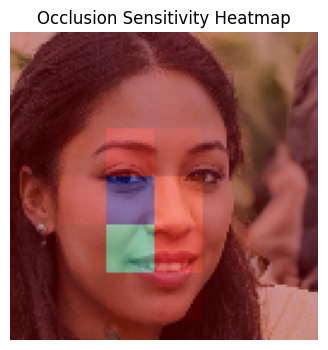

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


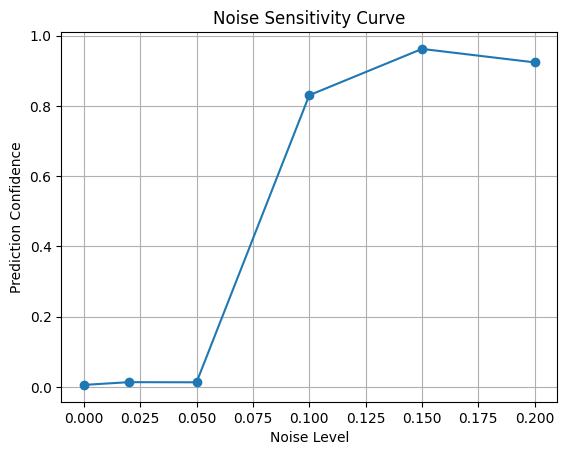

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


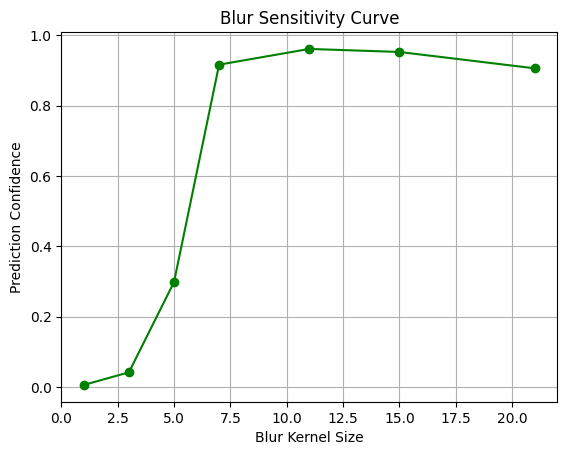

---- REAL IMAGE ----
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4

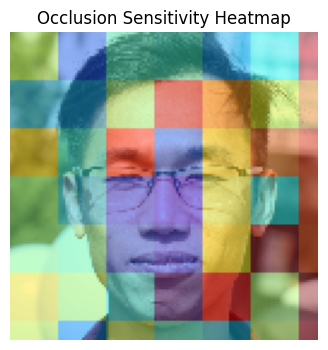

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


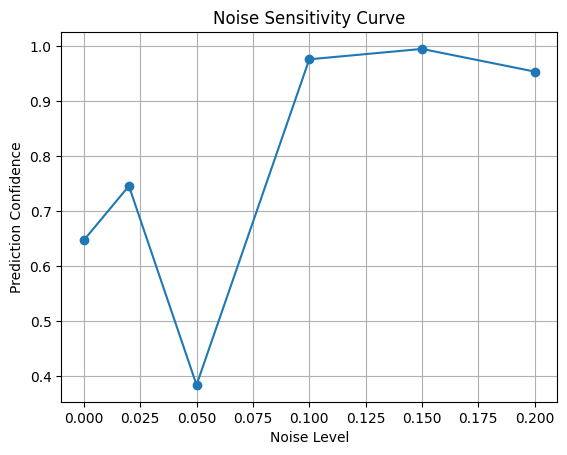

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


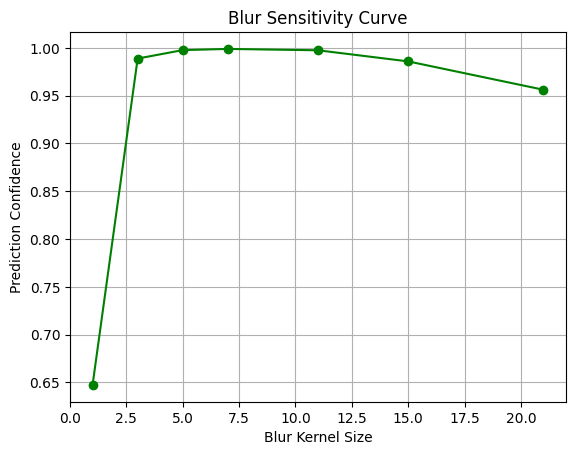

In [ ]:
fake_img = "/content/image-2019-02-19_015115.jpeg"
real_img = "/content/61230.jpeg"

print("---- FAKE IMAGE ----")
occlusion_heatmap(model, fake_img)
evaluate_noise(model, fake_img)
evaluate_blur(model, fake_img)

print("---- REAL IMAGE ----")
occlusion_heatmap(model, real_img)
evaluate_noise(model, real_img)
evaluate_blur(model, real_img)


Load Model

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/best_deepfake_model_v2.keras', compile=False)

print("Model loaded successfully!")


Model loaded successfully!


In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 128


Occlusion Sensitivity Function

In [ ]:
def occlusion_heatmap(model, img_path, patch=20):

    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original = img_rgb / 255.0

    heatmap = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)

    for y in range(0, IMG_SIZE, patch):
        for x in range(0, IMG_SIZE, patch):
            occluded = original.copy()
            occluded[y:y+patch, x:x+patch] = 0

            pred = model.predict(np.expand_dims(occluded, axis=0))[0][0]
            heatmap[y:y+patch, x:x+patch] = pred

    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heat_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-6)
    heat_color = cv2.applyColorMap(np.uint8(255 * heat_norm), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_rgb, 0.6, heat_color, 0.4, 0)

    plt.figure(figsize=(6,4))
    plt.imshow(overlay)
    plt.title("Occlusion Sensitivity Heatmap")
    plt.axis("off")
    plt.show()


Noise Sensitivity Curve

In [ ]:
# ===========================================
# 4. NOISE SENSITIVITY CURVE
# ===========================================

def evaluate_noise(model, img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

    noise_levels = [0, 0.02, 0.05, 0.1, 0.15, 0.2]
    preds = []

    for lvl in noise_levels:
        noisy = img + np.random.normal(0, lvl, img.shape)
        noisy = np.clip(noisy, 0, 1)
        preds.append(model.predict(np.expand_dims(noisy, axis=0))[0][0])

    plt.plot(noise_levels, preds, marker='o')
    plt.title("Noise Sensitivity Curve")
    plt.xlabel("Noise Level")
    plt.ylabel("Prediction Confidence")
    plt.grid(True)
    plt.show()


Blur Sensitivity Curve

In [ ]:
# ===========================================
# 5. BLUR SENSITIVITY CURVE
# ===========================================

def evaluate_blur(model, img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

    blur_levels = [1, 3, 5, 7, 11, 15, 21]
    preds = []

    for k in blur_levels:
        blurred = cv2.GaussianBlur(img, (k, k), 0)
        preds.append(model.predict(np.expand_dims(blurred, axis=0))[0][0])

    plt.plot(blur_levels, preds, marker='o', color='green')
    plt.title("Blur Sensitivity Curve")
    plt.xlabel("Blur Kernel Size")
    plt.ylabel("Prediction Confidence")
    plt.grid(True)
    plt.show()


Run on Fake Image

---- FAKE IMAGE ----
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━

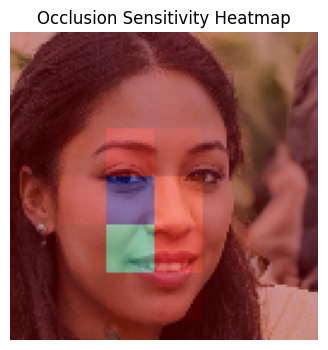

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


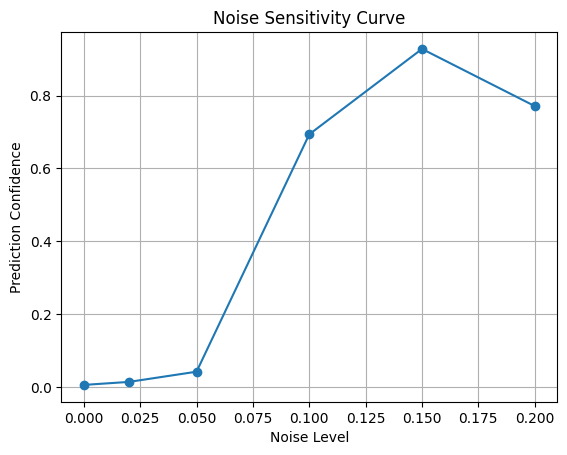

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


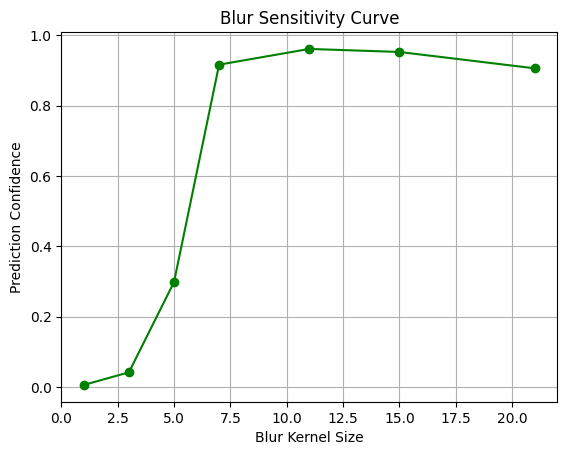

In [ ]:
fake_img = "/content/image-2019-02-19_015115.jpeg"

print("---- FAKE IMAGE ----")
occlusion_heatmap(model, fake_img)
evaluate_noise(model, fake_img)
evaluate_blur(model, fake_img)


Run on Real Image

---- REAL IMAGE ----
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

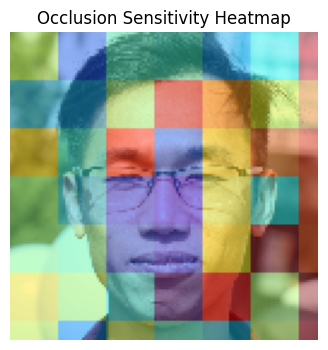

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


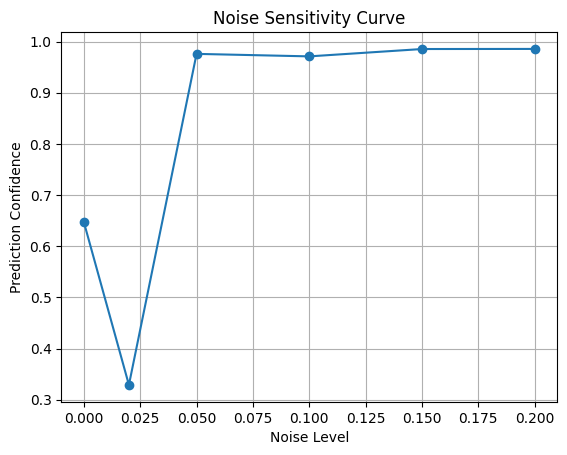

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


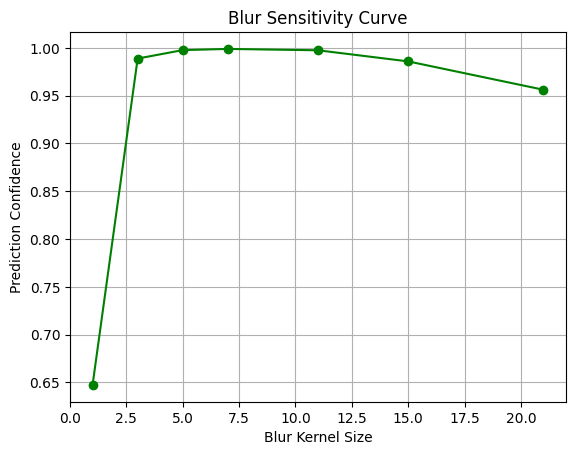

In [ ]:
real_img = "/content/61230.jpeg"

print("---- REAL IMAGE ----")
occlusion_heatmap(model, real_img)
evaluate_noise(model, real_img)
evaluate_blur(model, real_img)


Prediction Function, Confusion Matrix & Classification Report, ROC Curve & AUC Score, Model Architecture Diagram

In [ ]:
# ===========================
# 1. LOAD MODEL
# ===========================

from tensorflow.keras.models import load_model

model_path = "/content/drive/MyDrive/best_deepfake_model_v2.keras"
model = load_model(model_path, compile=False)

print("Model Loaded Successfully!")


Model Loaded Successfully!


In [ ]:
# ===========================
# 2. IMPORT LIBRARIES
# ===========================

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step

Prediction: FAKE
Confidence: 0.7910


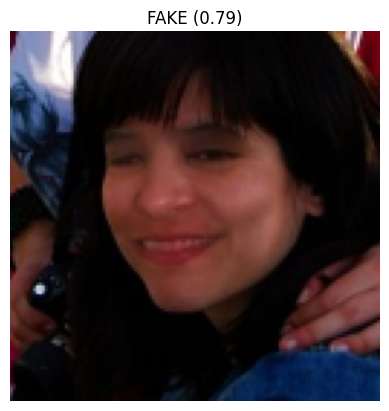

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step

Prediction: FAKE
Confidence: 0.9791


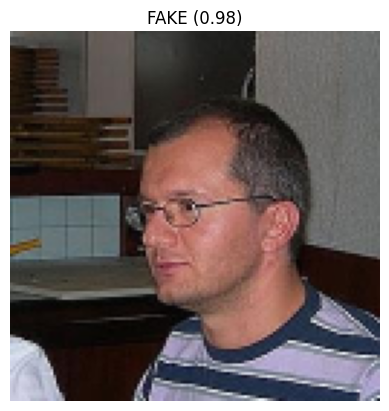

In [ ]:
# ===========================
# 3. PREDICT REAL / FAKE
# ===========================

IMG_SIZE = 128

def predict_image(model, img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_norm = img_rgb / 255.0
    img_input = np.expand_dims(img_norm, axis=0)

    pred = model.predict(img_input)[0][0]
    label = "FAKE" if pred > 0.5 else "REAL"

    print(f"\nPrediction: {label}")
    print(f"Confidence: {pred:.4f}")

    plt.imshow(img_rgb)
    plt.title(f"{label} ({pred:.2f})")
    plt.axis("off")
    plt.show()


# ===========================
# USE YOUR IMAGES HERE
# ===========================

predict_image(model, "/content/fake_1025.jpg")
predict_image(model, "/content/real_1034.jpg")



In [ ]:
-------------------------------------

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving 00014.jpg to 00014 (1).jpg


In [ ]:
import os
print(os.listdir("/content"))


['.config', '00014.jpg', 'Christy_Canyon_DSC_0121.JPG', '61230.jpeg', '00014 (1).jpg', 'fake_1025.jpg', 'deepfake_dataset', '140k-real-and-fake-faces.zip', '1 (1).jpg', 'kaggle (1).json', '.ipynb_checkpoints', 'drive', 'kaggle.json', 'sample_data']


In [ ]:
fake_img = "/content/fake_1025.jpg"
real_img  = "/content/00014.jpg"


FAKE IMAGE PREDICTION:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Prediction: FAKE | Confidence: 0.7910


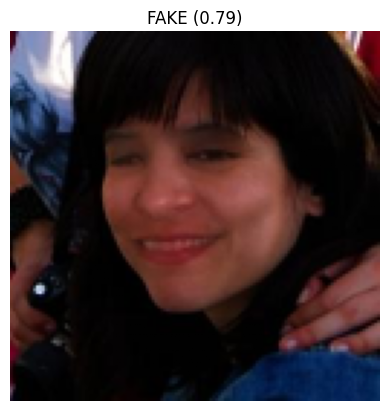

REAL IMAGE PREDICTION:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction: REAL | Confidence: 0.3545


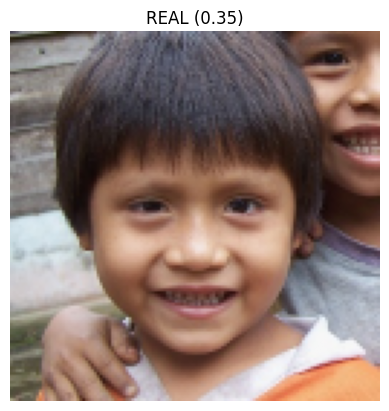

In [ ]:
print("FAKE IMAGE PREDICTION:")
predict_image(model, fake_img)

print("REAL IMAGE PREDICTION:")
predict_image(model, real_img)


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving 00014.jpg to 00014.jpg
Saving fake_1025.jpg to fake_1025.jpg


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!ls -l ~/.kaggle


total 4
-rw------- 1 root root 67 Nov 19 17:14 kaggle.json


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Prediction: REAL | Confidence: 0.1729


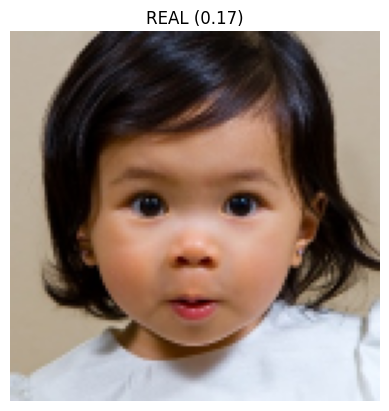

In [ ]:

predict_image(model, "deepfake_dataset/real_vs_fake/real-vs-fake/train/real/00003.jpg")



In [ ]:
from google.colab import files
files.download("deepfake_dataset/real_vs_fake/real-vs-fake/train/real/00014.jpg")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Prediction: REAL | Confidence: 0.3545


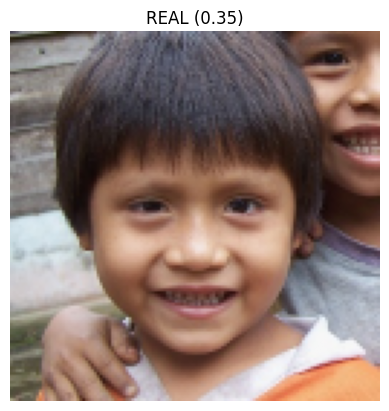

In [ ]:
predict_image(model, "/content/00014.jpg")


FINAL

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/best_deepfake_model_v2.keras", compile=False)
print("Model Loaded Successfully!")


Model Loaded Successfully!


In [ ]:
# ===========================
# 2. LOAD MODEL
# ===========================
model_path = "/content/drive/MyDrive/best_deepfake_model_v2.keras"
model = load_model(model_path, compile=False)

print("Model Loaded Successfully!")


Model Loaded Successfully!


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 128

def predict_image(model, img_path):
    img = cv2.imread(img_path)
    if img is None:
        print("❌ ERROR: Image not found at:", img_path)
        return

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_norm = img_rgb / 255.0
    img_input = np.expand_dims(img_norm, axis=0)

    pred = model.predict(img_input)[0][0]
    label = "FAKE" if pred > 0.5 else "REAL"

    print(f"\nPrediction: {label}")
    print(f"Confidence: {pred:.4f}")

    plt.imshow(img_rgb)
    plt.title(f"{label} ({pred:.2f})")
    plt.axis("off")
    plt.show()


FAKE IMAGE:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step

Prediction: FAKE
Confidence: 0.7910


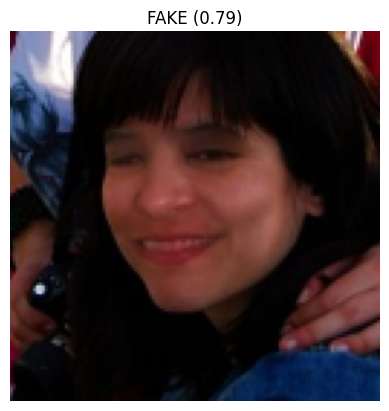

REAL IMAGE (00014.jpg):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

Prediction: REAL
Confidence: 0.3545


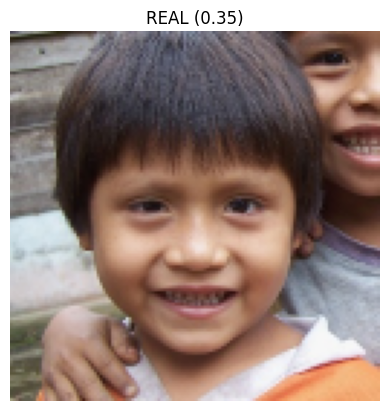

In [ ]:
fake_img = "/content/fake_1025.jpg"

real_img = "/content/00014.jpg"




print("FAKE IMAGE:")
predict_image(model, fake_img)

print("REAL IMAGE (00014.jpg):")
predict_image(model, real_img)





In [ ]:
!ls deepfake_dataset


real_vs_fake  test.csv	train.csv  valid.csv


In [ ]:
!ls deepfake_dataset/real_vs_fake/real-vs-fake



test  train  valid


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = 128


In [ ]:
test_path = "/content/deepfake_dataset/real_vs_fake/real-vs-fake/test"

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 20000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/best_deepfake_model_v2.keras", compile=False)
print("Model Loaded Successfully!")


Model Loaded Successfully!


Precision / Recall / F1

In [ ]:
from sklearn.metrics import classification_report

y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()

print(classification_report(y_true, y_pred_labels, target_names=["Fake", "Real"]))


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step
              precision    recall  f1-score   support

        Fake       0.90      0.87      0.88     10000
        Real       0.87      0.91      0.89     10000

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000



Confusion Matrix Heatmap

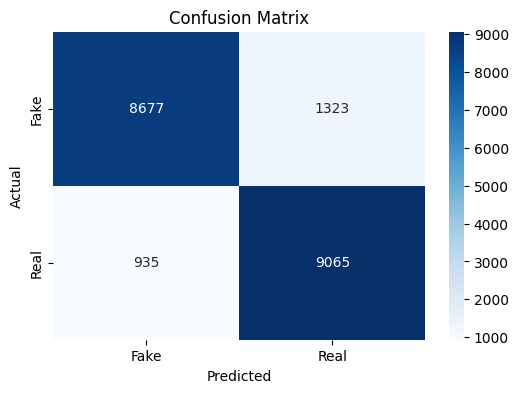

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


ROC Curve + AUC Score

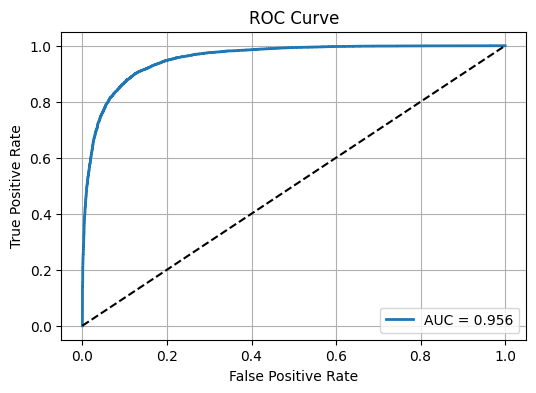

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], 'k--')  # diagonal baseline
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


Model Architecture Diagram

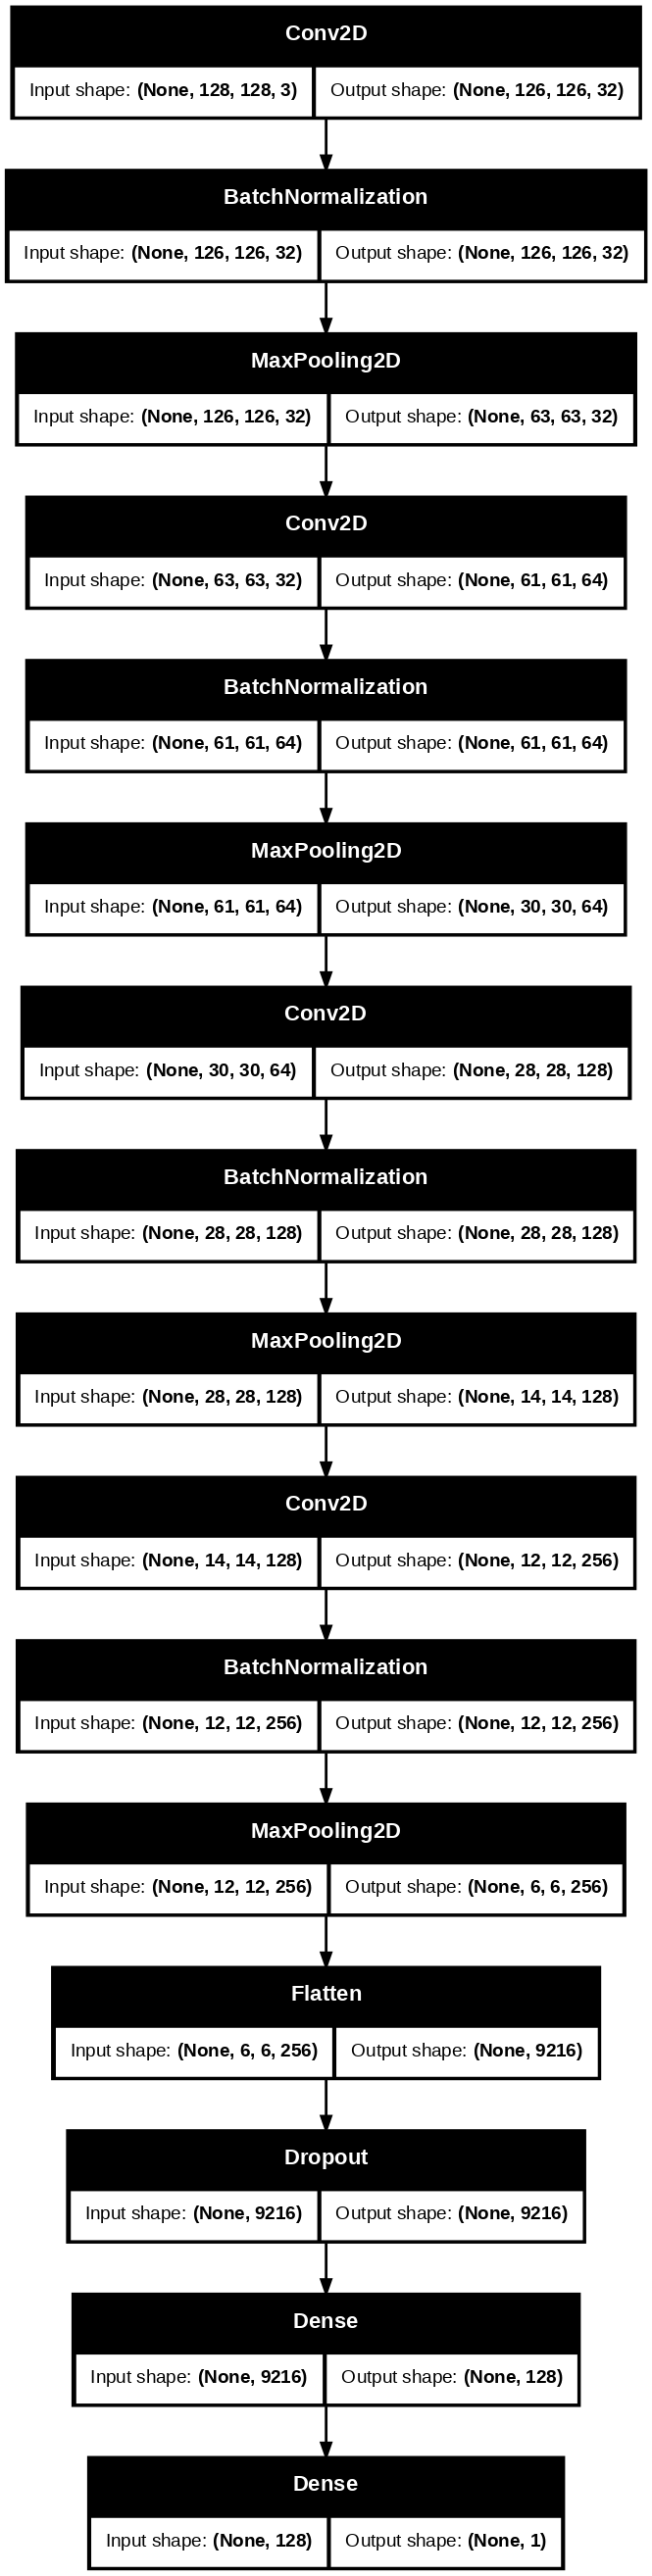

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="model_arch.png", show_shapes=True, dpi=100)

from IPython.display import Image
Image("model_arch.png")


SAVING


In [ ]:
!mkdir -p /content/drive/MyDrive/Deepfake_Project


In [ ]:
from graphviz import Digraph

# ==========================================
# 1. SYSTEM WORKFLOW DIAGRAM (2.1)
# ==========================================
dot = Digraph('Deepfake_Workflow', comment='System Workflow')
dot.attr(rankdir='TB', size='10')
dot.attr('node', shape='rect', style='filled', fillcolor='lightblue', fontname='Helvetica')

# Define Nodes
dot.node('A', 'Start', shape='ellipse', fillcolor='lightgrey')
dot.node('B', 'Input Image\n(Real or Fake)')
dot.node('C', 'Preprocessing\n(Resize 128x128, Normalize)')
dot.node('D', 'Load Trained Model\n(CNN w/ BatchNorm)')
dot.node('E', 'Model Prediction\n(Sigmoid Probability)')
dot.node('F', 'Decision Threshold\n(> 0.5)')
dot.node('G', 'Class: FAKE', fillcolor='salmon')
dot.node('H', 'Class: REAL', fillcolor='lightgreen')
dot.node('I', 'Explainability\n(Occlusion Heatmap / Noise Curve)')
dot.node('J', 'End', shape='ellipse', fillcolor='lightgrey')

# Define Edges
dot.edge('A', 'B')
dot.edge('B', 'C')
dot.edge('C', 'D')
dot.edge('D', 'E')
dot.edge('E', 'F')
dot.edge('F', 'G', label='Prob > 0.5')
dot.edge('F', 'H', label='Prob <= 0.5')
dot.edge('G', 'I')
dot.edge('H', 'I')
dot.edge('I', 'J')

# Render
dot.render('System_Workflow_Diagram', format='png', cleanup=True)
print("Generated: System_Workflow_Diagram.png")


# ==========================================
# 2. DATA PROCESSING PIPELINE (2.2)
# ==========================================
pipe = Digraph('Data_Pipeline', comment='Data Pipeline')
pipe.attr(rankdir='LR') # Left to Right
pipe.attr('node', shape='box', style='rounded,filled', fillcolor='white', fontname='Helvetica')

# Nodes
pipe.node('Raw', 'Raw Dataset\n(Train/Valid/Test)', fillcolor='lightyellow')
pipe.node('Gen', 'ImageDataGenerator\n(Keras)', fillcolor='lavender')
pipe.node('Aug', 'Augmentation (Train Only)\n- Rotate 20°\n- Shift 0.1\n- Shear/Zoom 0.1\n- Flip Horizontal', fillcolor='mistyrose')
pipe.node('Norm', 'Normalization\n(Rescale 1./255)', fillcolor='lightblue')
pipe.node('Resize', 'Resize\n(128 x 128)', fillcolor='lightblue')
pipe.node('Batch', 'Batching\n(Size=32)', fillcolor='lightgrey')
pipe.node('Model', 'CNN Model Input', shape='component')

# Edges
pipe.edge('Raw', 'Gen')
pipe.edge('Gen', 'Norm')
pipe.edge('Norm', 'Resize')
pipe.edge('Resize', 'Aug', label='Training Data')
pipe.edge('Resize', 'Batch', label='Test/Valid Data')
pipe.edge('Aug', 'Batch')
pipe.edge('Batch', 'Model')

# Render
pipe.render('Data_Pipeline_Diagram', format='png', cleanup=True)
print("Generated: Data_Pipeline_Diagram.png")

Generated: System_Workflow_Diagram.png
Generated: Data_Pipeline_Diagram.png


In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

# Load your model (ensure the path is correct)
# If your model is already loaded in the variable 'model', you can skip the loading line
try:
    model = load_model('/content/drive/MyDrive/best_deepfake_model_v2.keras', compile=False)
    print("Model loaded for plotting.")
except:
    print("Model variable already exists, using current model.")

# ==========================================
# 3. MODEL ARCHITECTURE DIAGRAM (2.3)
# ==========================================
# rankdir='LR' makes it horizontal (better for Word docs/Reports)
# show_shapes=True shows the (128, 128, 3) dimensions
plot_model(
    model,
    to_file='Model_Architecture_Diagram.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='LR',
    expand_nested=True,
    dpi=96
)
print("Generated: Model_Architecture_Diagram.png")

Model loaded for plotting.
Generated: Model_Architecture_Diagram.png


In [ ]:
!pip install gradio


In [ ]:
import gradio as gr
import cv2
import numpy as np
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/best_deepfake_model_v2.keras", compile=False)

IMG_SIZE = 128

def predict(img):
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)[0][0]

    label = "FAKE" if pred > 0.5 else "REAL"
    return f"{label} — Confidence: {pred:.4f}"

demo = gr.Interface(
    fn=predict,
    inputs="image",
    outputs="text",
    title="Deepfake Detector"
)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://20590f6cac5d0ab6e2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
